In [18]:
import warnings
warnings.filterwarnings('ignore')
print("="*80)
print("EXECUCIÓ COMPLETA DEL NOTEBOOK - ANÀLISI DE MODELS")
print("="*80)

EXECUCIÓ COMPLETA DEL NOTEBOOK - ANÀLISI DE MODELS


# Selecció de Models
En la Demo1 només este en compte la filtració de dades (Tractaments de valors faltants) i eliminació de columnes que no tenen correlació amb el **target = winner**.

- **Model 1:** Elimació de les columnes de la correlació
- **Model 2:** + Elimació de les columnes que determinen quin heroi a acabat amb una estructura
- **Model 3:** + Eliminació dels *first*

**NOTA:** Algunes de les funcions utilitzades estan en el document **funcions.py** per millorar al visualització del NoteBook

In [19]:
# Primer de tot carreguem les llibreries necessàries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as sk

from funcions import *

In [20]:
# Regressió logística
from sklearn.linear_model import LogisticRegression
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# SVM
from sklearn.svm import SVC
# XGBoost
from xgboost import XGBClassifier
# LightGBM
from lightgbm import LGBMClassifier
# CatBoost
from catboost import CatBoostClassifier

In [21]:
DataSet = pd.read_csv('../../LOL - Dataset/games.csv')

print("📊 RESUM DE LES DADES ORIGINALS:")
print(f"Files: {DataSet.shape[0]}, Columnes: {DataSet.shape[1]}")
print(f"\nValors NaN totals: {DataSet.isna().sum().sum()}")
print(f"Files amb NaN: {DataSet.isna().any(axis=1).sum()}")

# Eliminar duplicats
duplicated_rows = DataSet[DataSet.duplicated(keep=False)]
print(f"\n📋 Nombre de files duplicades: {len(duplicated_rows)} de {len(DataSet)}")
DataSet_cleaned = DataSet.drop_duplicates()
print(f"✅ Files després d'eliminar duplicats: {len(DataSet_cleaned)}")


📊 RESUM DE LES DADES ORIGINALS:
Files: 51490, Columnes: 61

Valors NaN totals: 0
Files amb NaN: 0

📋 Nombre de files duplicades: 861 de 51490
✅ Files després d'eliminar duplicats: 51053


Com hem determinat al final del document de **Correlació**, eliminarem els atributs que no tenen correlació directa amb el target **winner**

In [ ]:

cols_to_remove = [f't{team}_champ{i}id' for team in [1, 2] for i in range(1, 6)]
cols_to_remove += [f't{team}_champ{champ}_sum{s}' for team in [1, 2] for champ in range(1, 6) for s in [1,2]]
cols_to_remove += [f't{team}_ban{champ}' for team in [1, 2] for champ in range(1, 6)]

# Verificar quines columnes existeixen
existing_cols = [col for col in cols_to_remove if col in DataSet_cleaned.columns]
DataSet_cleaned = DataSet_cleaned.drop(columns=existing_cols, errors='ignore')
print(f"Columnes restants: {DataSet_cleaned.shape[1]}")


'\ncols_to_remove = [f\'t{team}_champ{i}id\' for team in [1, 2] for i in range(1, 6)]\ncols_to_remove += [f\'t{team}_champ{champ}_sum{s}\' for team in [1, 2] for champ in range(1, 6) for s in [1,2]]\ncols_to_remove += [f\'t{team}_ban{champ}\' for team in [1, 2] for champ in range(1, 6)]\n\n# Verificar quines columnes existeixen\nexisting_cols = [col for col in cols_to_remove if col in DataSet_cleaned.columns]\nDataSet_cleaned = DataSet_cleaned.drop(columns=existing_cols, errors=\'ignore\')\nprint(f"✅ Columnes restants: {DataSet_cleaned.shape[1]}")\n'

## Preparació de les dades d'entrenament i predicció
A continuació farem la validació creuada i la selecció dels hiperparàmetres

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def split_data(X, y, test_size=0.2, val_size=0.2, random_state=42):
    """
    Separa les dades en train, validation i test
    """
    # Primer separació: train+val (80%) i test (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Segona separació: train (60%) i val (20%)
    val_relative_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_relative_size, 
        random_state=random_state, stratify=y_train_val
    )
    
    print(f"Train shape: {X_train.shape}")
    print(f"Validation shape: {X_val.shape}")
    print(f"Test shape: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def scale_data(X_train, X_val, X_test, method='standard'):
    """
    Normalitza/estandarditza les dades
    """
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Mètode ha de ser 'standard' o 'minmax'")
    
    # Entrenar el scaler només amb les dades d'entrenament
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler


In [24]:
X = DataSet_cleaned.drop('winner', axis=1)
y = DataSet_cleaned['winner']

print(f"\n🎯 DATES PER A MODELACIÓ:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nDistribució de la variable objectiu:")
print(y.value_counts(normalize=True))
y = y.map({1: 0, 2: 1})


🎯 DATES PER A MODELACIÓ:
X shape: (51053, 60)
y shape: (51053,)

Distribució de la variable objectiu:
winner
1    0.506474
2    0.493526
Name: proportion, dtype: float64


In [25]:
# Separar dades
print(f"\n{'='*60}")
print("SEPARANT LES DADES (Train/Val/Test)")
print(f"{'='*60}")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X, y, test_size=0.2, val_size=0.2
)

# Escalar dades
print(f"\n{'='*60}")
print("NORMALITZANT LES DADES")
print(f"{'='*60}")
X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_data(
    X_train, X_val, X_test, method='standard'
)


SEPARANT LES DADES (Train/Val/Test)
Train shape: (30631, 60)
Validation shape: (10211, 60)
Test shape: (10211, 60)

NORMALITZANT LES DADES



MODEL 1: REGRESSIÓ LOGÍSTICA

VALIDACIÓ CREUADA (CV=5)
Scores per cada fold: [0.96180839 0.96180215 0.95445642 0.96147568 0.96065948]
Score mitjà (accuracy): 0.9600
Desviació estàndard: 0.0028
Interval de confiança 95%: [0.9545, 0.9656]
Scores per cada fold: [0.96180839 0.96180215 0.95445642 0.96147568 0.96065948]
Score mitjà (accuracy): 0.9600
Desviació estàndard: 0.0028
Interval de confiança 95%: [0.9545, 0.9656]


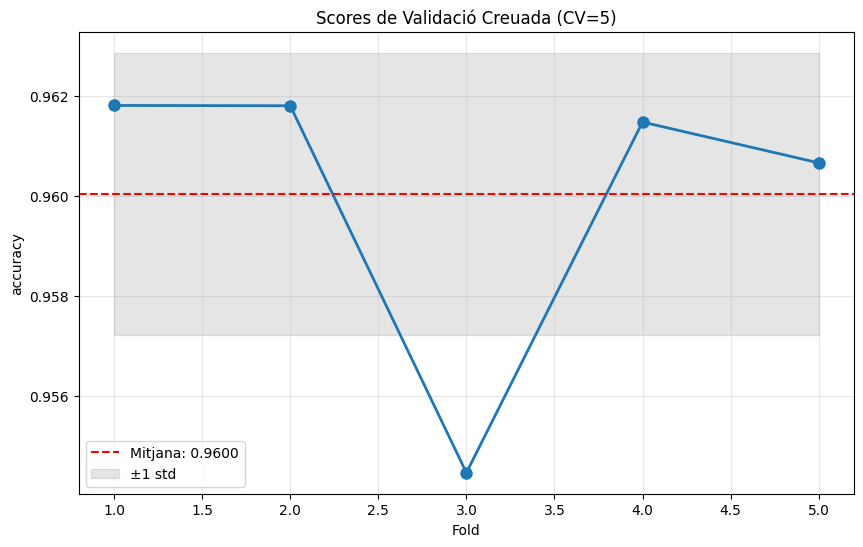

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Millors paràmetres: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.1}
Millor score (CV) [accuracy]: 0.9606

AVALUACIÓ DEL MODEL: Regressió Logística (Val)
Valors únics a y_test: [0 1]
Millors paràmetres: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.1}
Millor score (CV) [accuracy]: 0.9606

AVALUACIÓ DEL MODEL: Regressió Logística (Val)
Valors únics a y_test: [0 1]


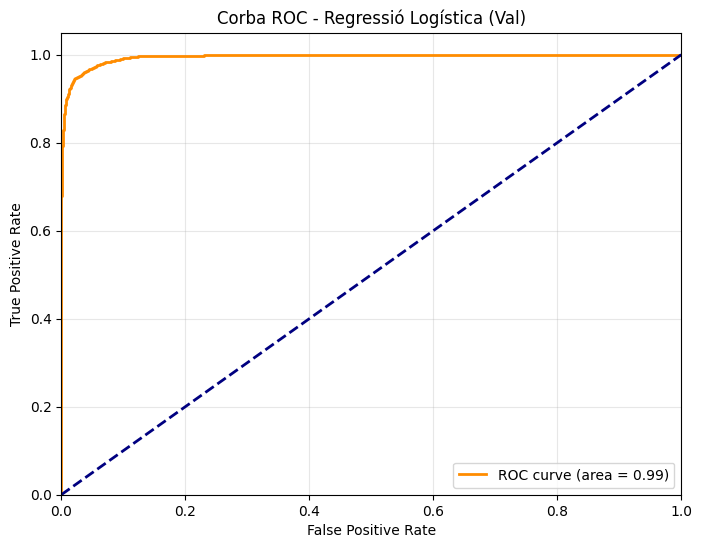


📊 MÈTRIQUES D'AVALUACIÓ:
Accuracy: 0.9603
Precision: 0.9550
Recall: 0.9651
F1-Score: 0.9600
ROC-AUC: 0.9948

📊 Matriu de Confusió:
[[4943  229]
 [ 176 4863]]


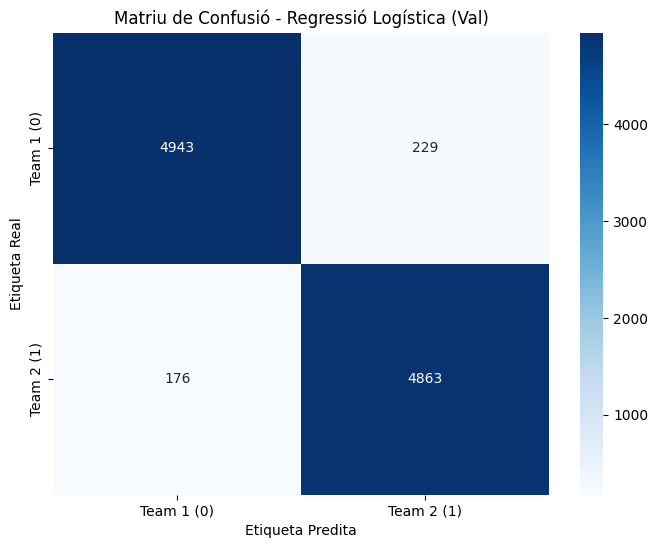


📋 Informe de Classificació:
              precision    recall  f1-score   support

  Team 1 (0)       0.97      0.96      0.96      5172
  Team 2 (1)       0.96      0.97      0.96      5039

    accuracy                           0.96     10211
   macro avg       0.96      0.96      0.96     10211
weighted avg       0.96      0.96      0.96     10211



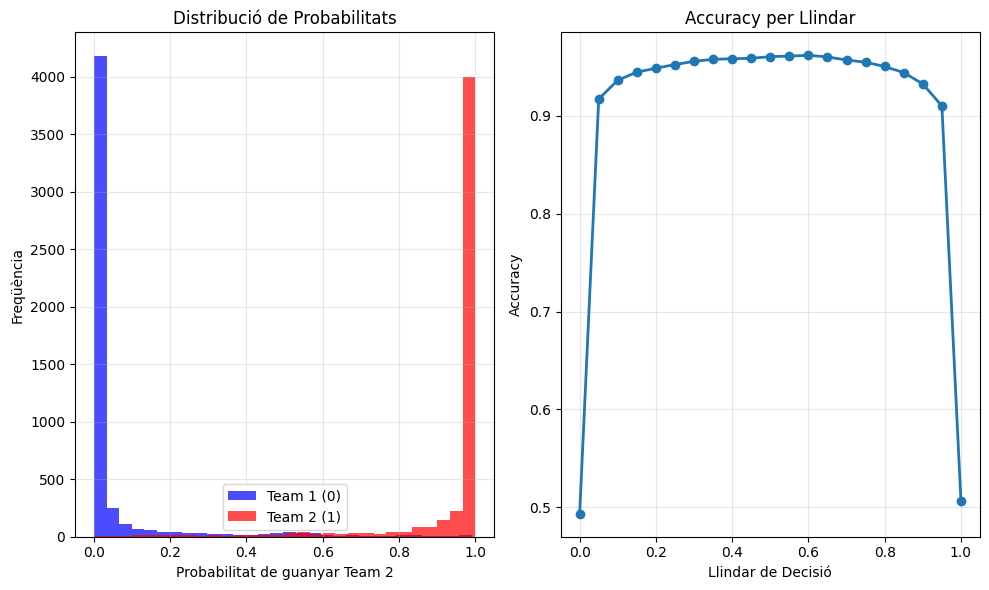

In [26]:
# Model 1: Regressió Logística
print(f"\n{'='*60}")
print("MODEL 1: REGRESSIÓ LOGÍSTICA")
print(f"{'='*60}")

from sklearn.linear_model import LogisticRegression

# Validació creuada
lr_base = LogisticRegression(max_iter=2000, random_state=42)
cv_scores_lr = cross_validation_analysis(lr_base, X_train_scaled, y_train, cv=5)

# Ajust d'hiperparàmetres
param_grids = get_param_grids()
lr_best, lr_params, lr_search = hyperparameter_tuning(
    lr_base, 
    param_grids['logistic'], 
    X_train_scaled, 
    y_train, 
    cv=5, 
    method='random'
)

# Avaluació
lr_metrics, lr_cm = evaluate_model(lr_best, X_val_scaled, y_val, "Regressió Logística (Val)")

# Guardar resultats
results = {}
results['Logistic Regression'] = {
    'model': lr_best,
    'params': lr_params,
    'cv_score': cv_scores_lr.mean(),
    'val_metrics': lr_metrics
}



MODEL 2: RANDOM FOREST

VALIDACIÓ CREUADA (CV=5)
Scores per cada fold: [0.96719439 0.96751551 0.96425073 0.96898466 0.96735227]
Score mitjà (accuracy): 0.9671
Desviació estàndard: 0.0015
Interval de confiança 95%: [0.9640, 0.9701]
Scores per cada fold: [0.96719439 0.96751551 0.96425073 0.96898466 0.96735227]
Score mitjà (accuracy): 0.9671
Desviació estàndard: 0.0015
Interval de confiança 95%: [0.9640, 0.9701]


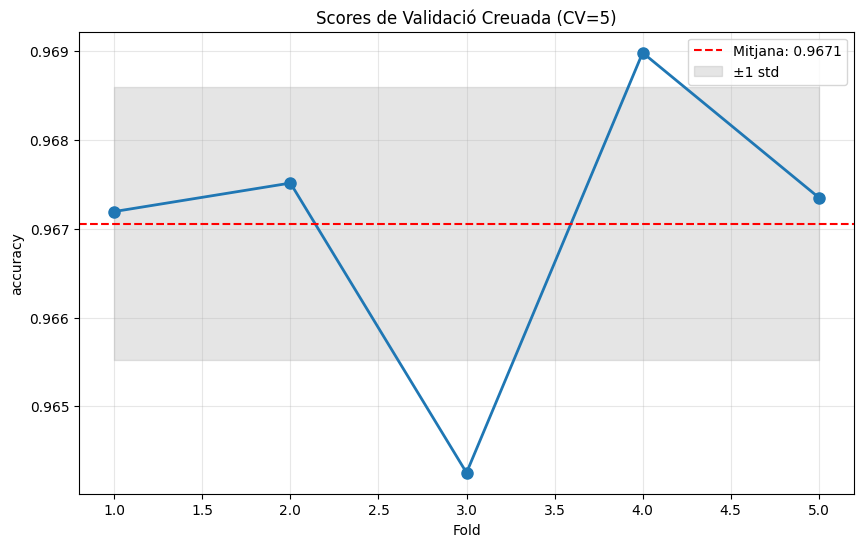

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Millors paràmetres: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Millor score (CV) [accuracy]: 0.9683

AVALUACIÓ DEL MODEL: Random Forest (Val)
Valors únics a y_test: [0 1]
Millors paràmetres: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Millor score (CV) [accuracy]: 0.9683

AVALUACIÓ DEL MODEL: Random Forest (Val)
Valors únics a y_test: [0 1]


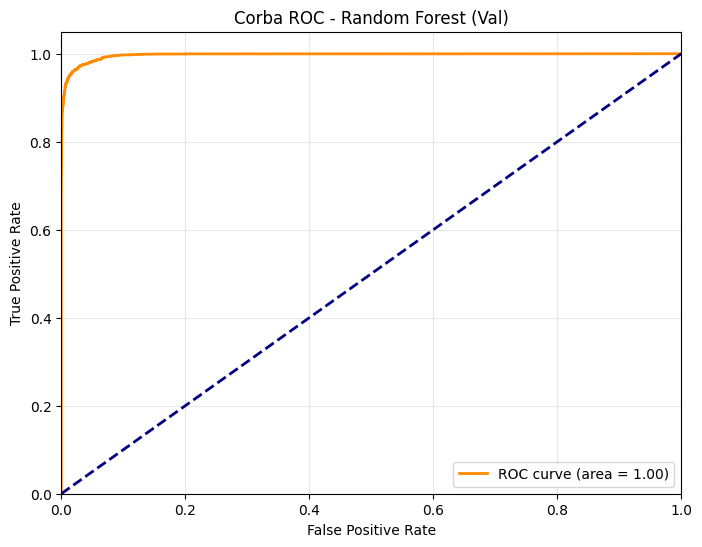


📊 MÈTRIQUES D'AVALUACIÓ:
Accuracy: 0.9707
Precision: 0.9673
Recall: 0.9736
F1-Score: 0.9704
ROC-AUC: 0.9969

📊 Matriu de Confusió:
[[5006  166]
 [ 133 4906]]


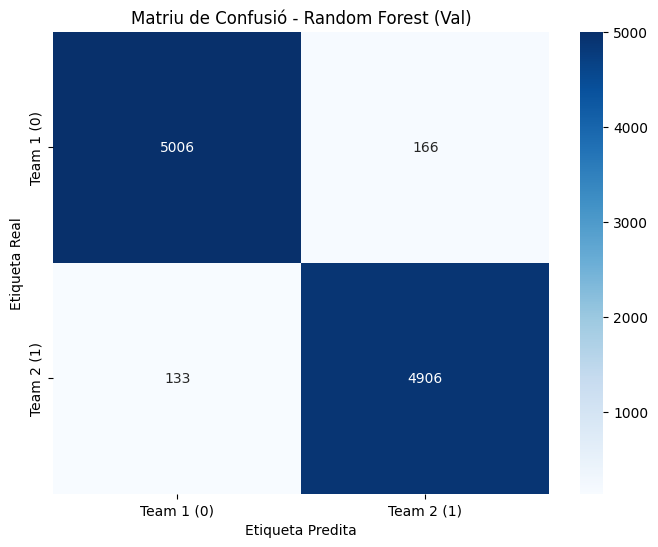


📋 Informe de Classificació:
              precision    recall  f1-score   support

  Team 1 (0)       0.97      0.97      0.97      5172
  Team 2 (1)       0.97      0.97      0.97      5039

    accuracy                           0.97     10211
   macro avg       0.97      0.97      0.97     10211
weighted avg       0.97      0.97      0.97     10211



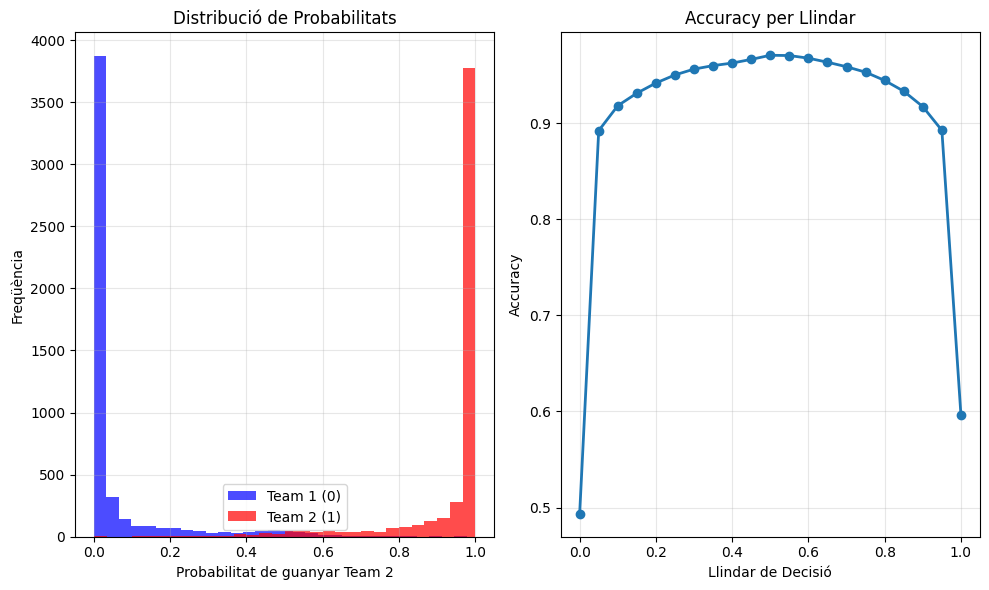

In [27]:
# Cèl·lula 8: Model 2 - Random Forest
print(f"\n{'='*60}")
print("MODEL 2: RANDOM FOREST")
print(f"{'='*60}")

from sklearn.ensemble import RandomForestClassifier

# Validació creuada
rf_base = RandomForestClassifier(random_state=42)
cv_scores_rf = cross_validation_analysis(rf_base, X_train, y_train, cv=5)

# Ajust d'hiperparàmetres
rf_best, rf_params, rf_search = hyperparameter_tuning(
    rf_base, 
    param_grids['random_forest'], 
    X_train, 
    y_train, 
    cv=5, 
    method='random'
)

# Avaluació
rf_metrics, rf_cm = evaluate_model(rf_best, X_val, y_val, "Random Forest (Val)")

# Guardar resultats
results['Random Forest'] = {
    'model': rf_best,
    'params': rf_params,
    'cv_score': cv_scores_rf.mean(),
    'val_metrics': rf_metrics
}


MODEL 3: GRADIENT BOOSTING

VALIDACIÓ CREUADA (CV=5)
Scores per cada fold: [0.96654154 0.96980085 0.96669931 0.9733921  0.96882142]
Score mitjà (accuracy): 0.9691
Desviació estàndard: 0.0025
Interval de confiança 95%: [0.9641, 0.9740]
Scores per cada fold: [0.96654154 0.96980085 0.96669931 0.9733921  0.96882142]
Score mitjà (accuracy): 0.9691
Desviació estàndard: 0.0025
Interval de confiança 95%: [0.9641, 0.9740]


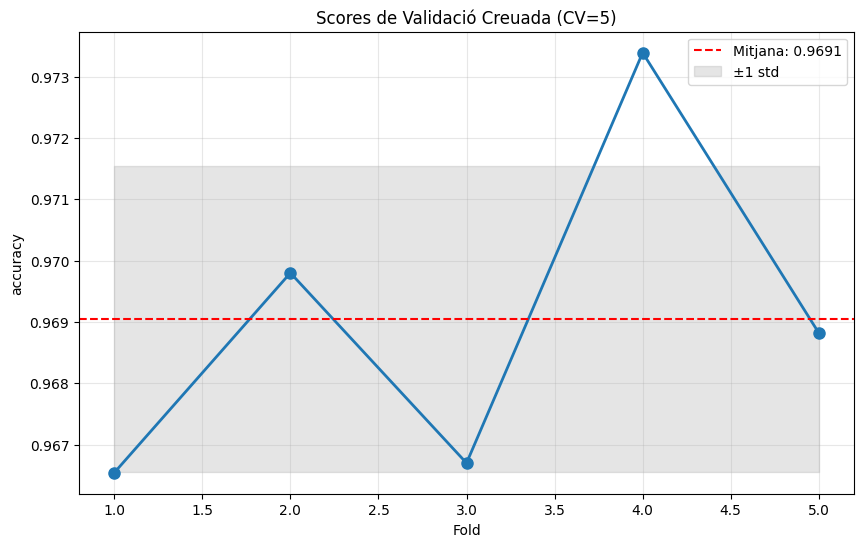

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Millors paràmetres: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4, 'learning_rate': 0.1}
Millor score (CV) [accuracy]: 0.9707

AVALUACIÓ DEL MODEL: Gradient Boosting (Val)
Valors únics a y_test: [0 1]
Millors paràmetres: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4, 'learning_rate': 0.1}
Millor score (CV) [accuracy]: 0.9707

AVALUACIÓ DEL MODEL: Gradient Boosting (Val)
Valors únics a y_test: [0 1]


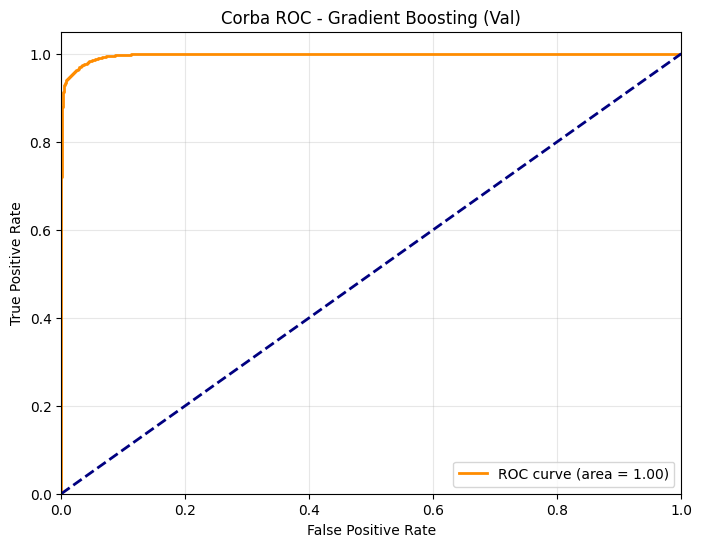


📊 MÈTRIQUES D'AVALUACIÓ:
Accuracy: 0.9694
Precision: 0.9650
Recall: 0.9734
F1-Score: 0.9692
ROC-AUC: 0.9971

📊 Matriu de Confusió:
[[4994  178]
 [ 134 4905]]


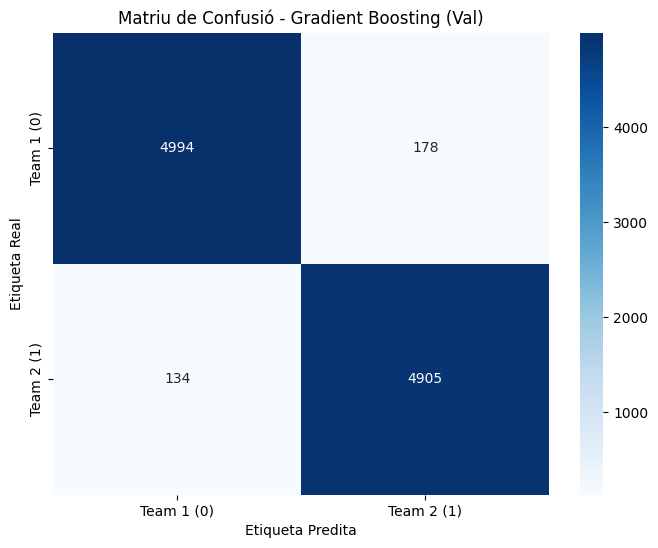


📋 Informe de Classificació:
              precision    recall  f1-score   support

  Team 1 (0)       0.97      0.97      0.97      5172
  Team 2 (1)       0.96      0.97      0.97      5039

    accuracy                           0.97     10211
   macro avg       0.97      0.97      0.97     10211
weighted avg       0.97      0.97      0.97     10211



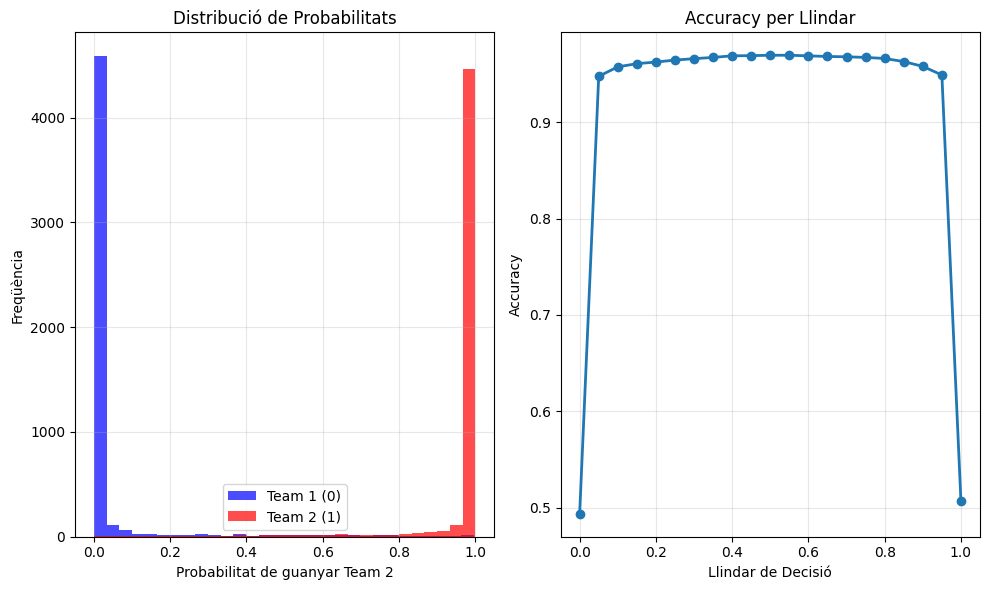

In [28]:
# Cèl·lula 9: Model 3 - Gradient Boosting
print(f"\n{'='*60}")
print("MODEL 3: GRADIENT BOOSTING")
print(f"{'='*60}")

from sklearn.ensemble import GradientBoostingClassifier

# Validació creuada
gb_base = GradientBoostingClassifier(random_state=42)
cv_scores_gb = cross_validation_analysis(gb_base, X_train, y_train, cv=5)

# Ajust d'hiperparàmetres
gb_best, gb_params, gb_search = hyperparameter_tuning(
    gb_base, 
    param_grids['gradient_boosting'], 
    X_train, 
    y_train, 
    cv=5, 
    method='random'
)

# Avaluació
gb_metrics, gb_cm = evaluate_model(gb_best, X_val, y_val, "Gradient Boosting (Val)")

# Guardar resultats
results['Gradient Boosting'] = {
    'model': gb_best,
    'params': gb_params,
    'cv_score': cv_scores_gb.mean(),
    'val_metrics': gb_metrics
}


MODEL 4: SVM

VALIDACIÓ CREUADA (CV=5)
Scores per cada fold: [0.96131875 0.96180215 0.96180215 0.96539341 0.96376102]
Score mitjà (accuracy): 0.9628
Desviació estàndard: 0.0015
Interval de confiança 95%: [0.9598, 0.9658]
Scores per cada fold: [0.96131875 0.96180215 0.96180215 0.96539341 0.96376102]
Score mitjà (accuracy): 0.9628
Desviació estàndard: 0.0015
Interval de confiança 95%: [0.9598, 0.9658]


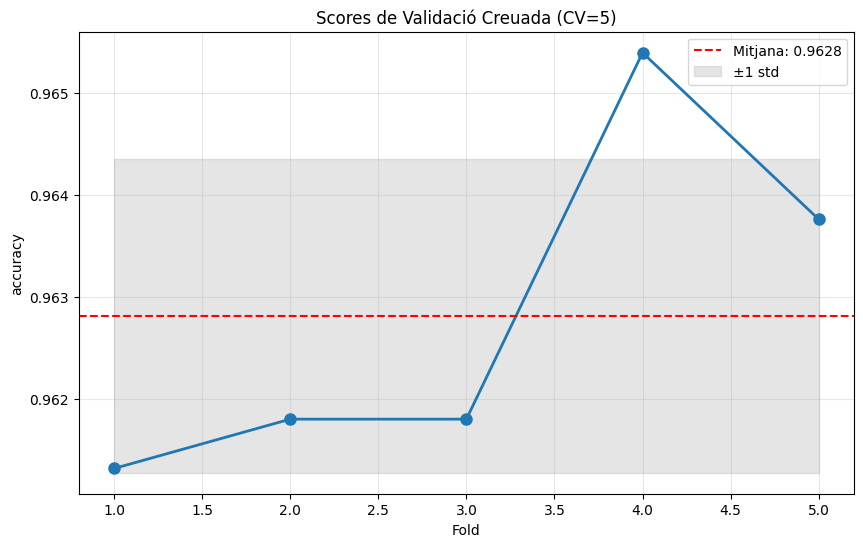

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Millors paràmetres: {'kernel': 'rbf', 'gamma': 'auto', 'C': 1}
Millor score (CV) [accuracy]: 0.9620

AVALUACIÓ DEL MODEL: SVM (Val)
Millors paràmetres: {'kernel': 'rbf', 'gamma': 'auto', 'C': 1}
Millor score (CV) [accuracy]: 0.9620

AVALUACIÓ DEL MODEL: SVM (Val)
Valors únics a y_test: [0 1]
Valors únics a y_test: [0 1]


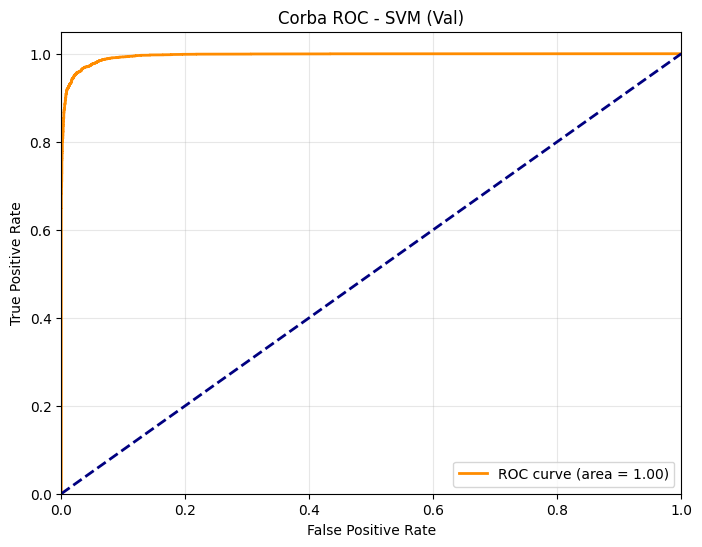


📊 MÈTRIQUES D'AVALUACIÓ:
Accuracy: 0.9656
Precision: 0.9653
Recall: 0.9651
F1-Score: 0.9652
ROC-AUC: 0.9956

📊 Matriu de Confusió:
[[4997  175]
 [ 176 4863]]


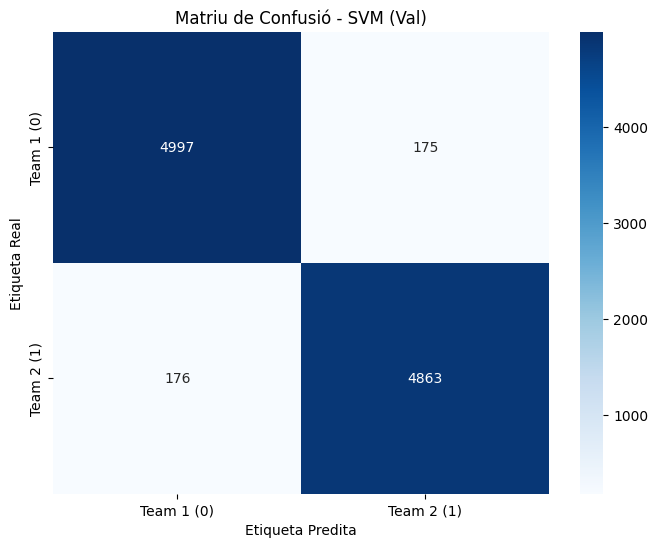


📋 Informe de Classificació:
              precision    recall  f1-score   support

  Team 1 (0)       0.97      0.97      0.97      5172
  Team 2 (1)       0.97      0.97      0.97      5039

    accuracy                           0.97     10211
   macro avg       0.97      0.97      0.97     10211
weighted avg       0.97      0.97      0.97     10211



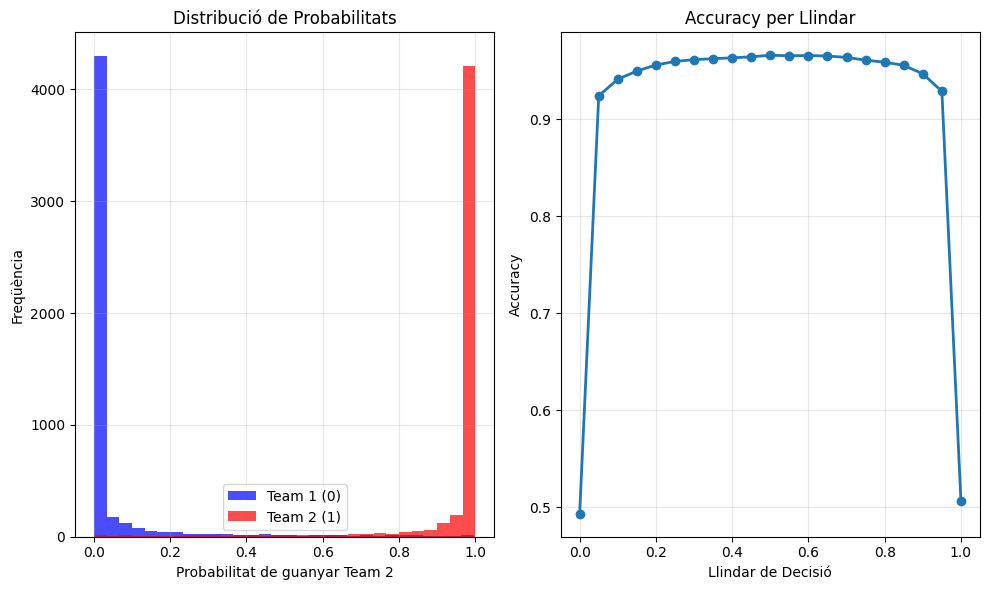

In [29]:
# Cèl·lula 10: Model 4 - SVM (necessita scaling)
print(f"\n{'='*60}")
print("MODEL 4: SVM")
print(f"{'='*60}")

from sklearn.svm import SVC

# Validació creuada
svm_base = SVC(probability=True, random_state=42)
cv_scores_svm = cross_validation_analysis(svm_base, X_train_scaled, y_train, cv=5)

# Ajust d'hiperparàmetres (versió simplificada i més ràpida)
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_best, svm_params, svm_search = hyperparameter_tuning(
    svm_base, 
    svm_param_grid, 
    X_train_scaled, 
    y_train, 
    cv=3,  # Reducit a 3 folds per velocitat
    method='random'
)

# Avaluació
svm_metrics, svm_cm = evaluate_model(svm_best, X_val_scaled, y_val, "SVM (Val)")

# Guardar resultats
results['SVM'] = {
    'model': svm_best,
    'params': svm_params,
    'cv_score': cv_scores_svm.mean(),
    'val_metrics': svm_metrics
}


COMPARACIÓ DE TOTS ELS MODELS

📊 TAULA DE COMPARACIÓ:
                 Model  CV Score  Val Accuracy  Val Precision  Val Recall  \
1        Random Forest  0.967060      0.970718       0.967271    0.973606   
2    Gradient Boosting  0.969051      0.969445       0.964981    0.973407   
3                  SVM  0.962815      0.965625       0.965264    0.965072   
0  Logistic Regression  0.960040      0.960337       0.955027    0.965072   

   Val F1-Score  
1      0.970428  
2      0.969176  
3      0.965168  
0      0.960024  


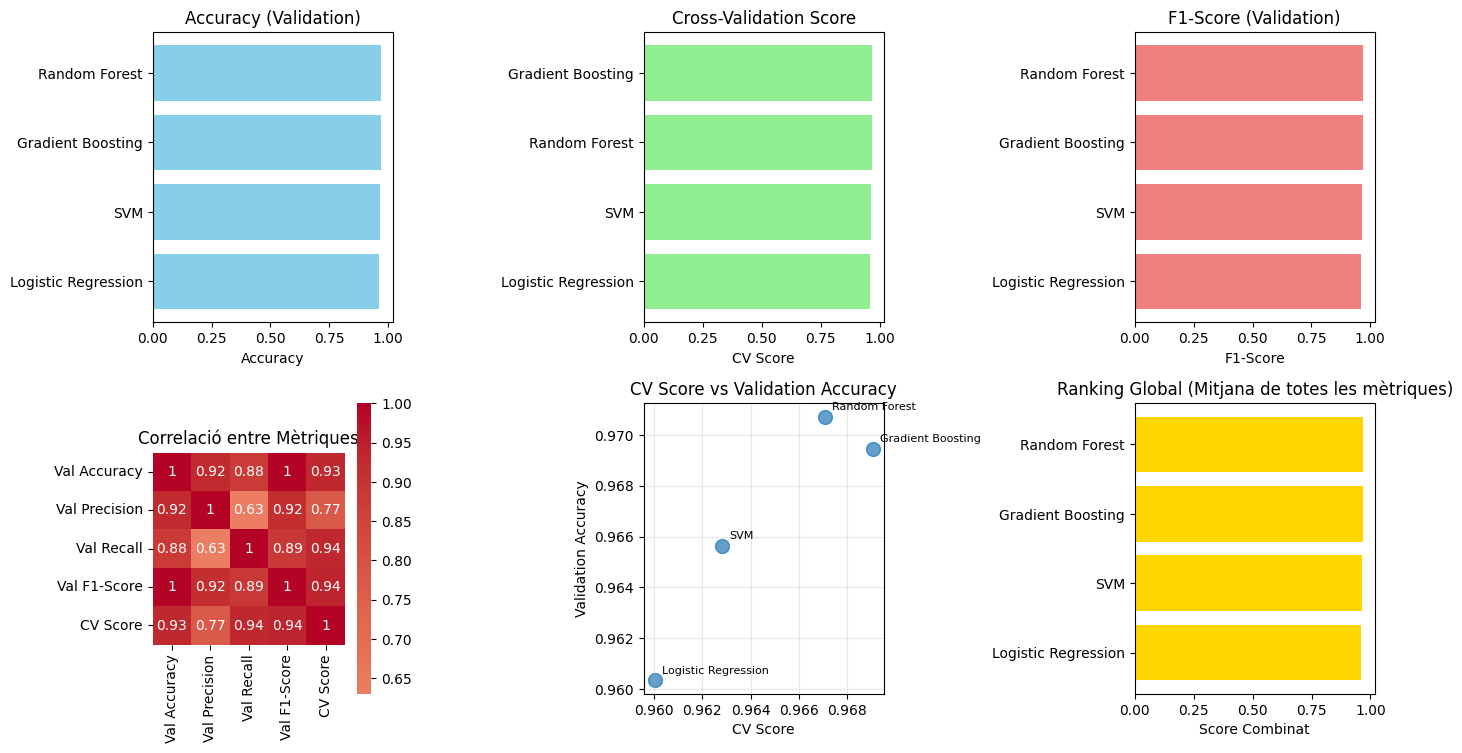

In [30]:
# Cèl·lula 11: COMPARACIÓ DE TOTS ELS MODELS
print(f"\n{'='*60}")
print("COMPARACIÓ DE TOTS ELS MODELS")
print(f"{'='*60}")

# Crear dataframe comparatiu
comparison_data = []
for model_name, model_info in results.items():
    comparison_data.append({
        'Model': model_name,
        'CV Score': model_info['cv_score'],
        'Val Accuracy': model_info['val_metrics']['Accuracy'],
        'Val Precision': model_info['val_metrics']['Precision'],
        'Val Recall': model_info['val_metrics']['Recall'],
        'Val F1-Score': model_info['val_metrics']['F1-Score']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 TAULA DE COMPARACIÓ:")
print(comparison_df.sort_values('Val Accuracy', ascending=False))

# Gràfic de comparació
plt.figure(figsize=(14, 8))

# Accuracy comparatiu
plt.subplot(2, 3, 1)
sorted_df = comparison_df.sort_values('Val Accuracy', ascending=True)
plt.barh(sorted_df['Model'], sorted_df['Val Accuracy'], color='skyblue')
plt.title('Accuracy (Validation)')
plt.xlabel('Accuracy')

# CV Score comparatiu
plt.subplot(2, 3, 2)
sorted_df = comparison_df.sort_values('CV Score', ascending=True)
plt.barh(sorted_df['Model'], sorted_df['CV Score'], color='lightgreen')
plt.title('Cross-Validation Score')
plt.xlabel('CV Score')

# F1-Score comparatiu
plt.subplot(2, 3, 3)
sorted_df = comparison_df.sort_values('Val F1-Score', ascending=True)
plt.barh(sorted_df['Model'], sorted_df['Val F1-Score'], color='lightcoral')
plt.title('F1-Score (Validation)')
plt.xlabel('F1-Score')

# Matriu de correlació de mètriques
plt.subplot(2, 3, 4)
metrics_corr = comparison_df[['Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1-Score', 'CV Score']].corr()
sns.heatmap(metrics_corr, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlació entre Mètriques')

# Scatter plot: CV Score vs Val Accuracy
plt.subplot(2, 3, 5)
plt.scatter(comparison_df['CV Score'], comparison_df['Val Accuracy'], s=100, alpha=0.7)
for i, row in comparison_df.iterrows():
    plt.annotate(row['Model'], (row['CV Score'], row['Val Accuracy']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('CV Score')
plt.ylabel('Validation Accuracy')
plt.title('CV Score vs Validation Accuracy')
plt.grid(True, alpha=0.3)

# Ranking global
plt.subplot(2, 3, 6)
# Crear score combinat (mitjana de totes les mètriques)
comparison_df['Combined Score'] = comparison_df[['Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1-Score', 'CV Score']].mean(axis=1)
sorted_df = comparison_df.sort_values('Combined Score', ascending=True)
plt.barh(sorted_df['Model'], sorted_df['Combined Score'], color='gold')
plt.title('Ranking Global (Mitjana de totes les mètriques)')
plt.xlabel('Score Combinat')

plt.tight_layout()
plt.show()


SELECCIÓ DEL MILLOR MODEL
🎯 MILLOR MODEL SELECCIONAT: Random Forest
📊 Paràmetres: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
🏆 Validation Accuracy: 0.9707

AVALUACIÓ FINAL AMB TEST SET

AVALUACIÓ DEL MODEL: Random Forest (Test Final)
Valors únics a y_test: [0 1]


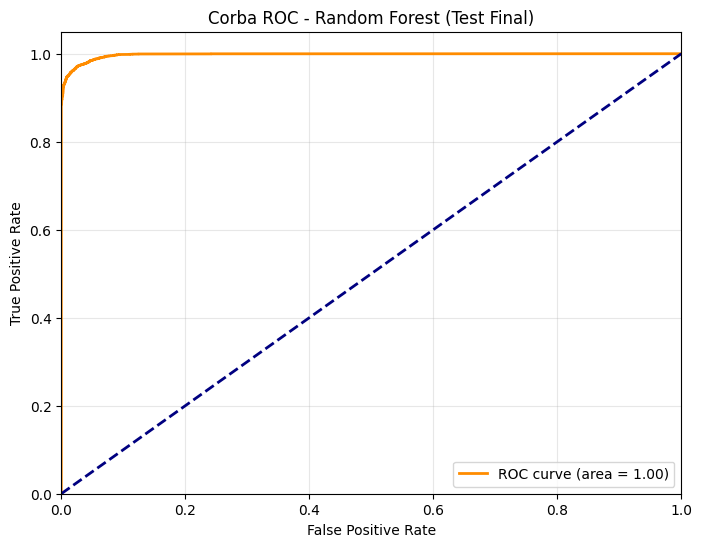


📊 MÈTRIQUES D'AVALUACIÓ:
Accuracy: 0.9721
Precision: 0.9698
Recall: 0.9738
F1-Score: 0.9718
ROC-AUC: 0.9976

📊 Matriu de Confusió:
[[5019  153]
 [ 132 4907]]


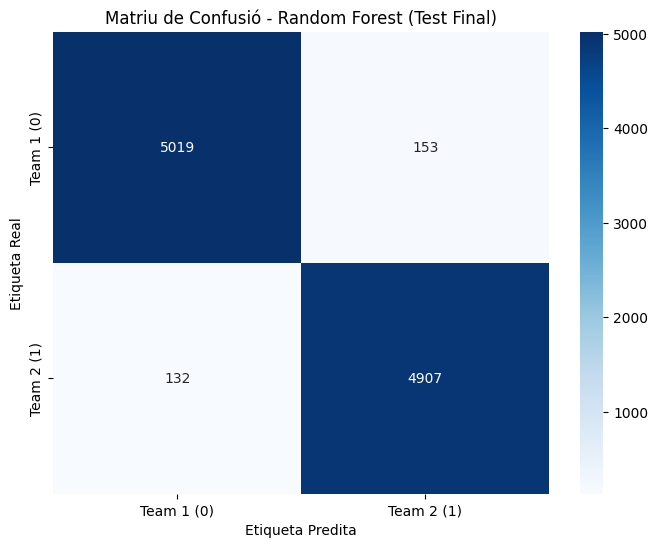


📋 Informe de Classificació:
              precision    recall  f1-score   support

  Team 1 (0)       0.97      0.97      0.97      5172
  Team 2 (1)       0.97      0.97      0.97      5039

    accuracy                           0.97     10211
   macro avg       0.97      0.97      0.97     10211
weighted avg       0.97      0.97      0.97     10211



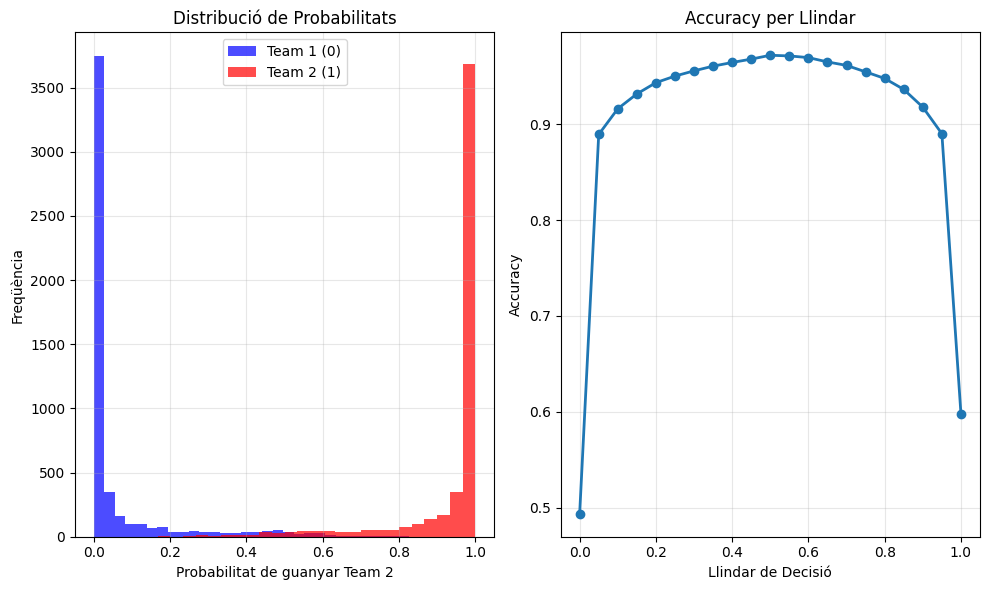

In [31]:
# Cèl·lula 12: SELECCIÓ DEL MILLOR MODEL I AVALUACIÓ FINAL
print(f"\n{'='*60}")
print("SELECCIÓ DEL MILLOR MODEL")
print(f"{'='*60}")

# Seleccionar el millor model basat en accuracy de validació
best_model_name = comparison_df.loc[comparison_df['Val Accuracy'].idxmax(), 'Model']
best_model_info = results[best_model_name]
best_model = best_model_info['model']

print(f"🎯 MILLOR MODEL SELECCIONAT: {best_model_name}")
print(f"📊 Paràmetres: {best_model_info['params']}")
print(f"🏆 Validation Accuracy: {best_model_info['val_metrics']['Accuracy']:.4f}")

# Determinar si cal escalar les dades per al millor model
needs_scaling = best_model_name in ['Logistic Regression', 'SVM']
X_test_to_use = X_test_scaled if needs_scaling else X_test

# AVALUACIÓ FINAL AMB TEST SET
print(f"\n{'='*60}")
print("AVALUACIÓ FINAL AMB TEST SET")
print(f"{'='*60}")

# Avaluar el millor model amb el test set
test_metrics, test_cm = evaluate_model(best_model, X_test_to_use, y_test, 
                                       f"{best_model_name} (Test Final)")

In [32]:
# Cèl·lula 13: RESUM FINAL I CONCLUSIONS
print(f"\n{'='*60}")
print("RESUM FINAL I CONCLUSIONS")
print(f"{'='*60}")

print(f"\n📈 PERFORMANCE FINAL DEL MILLOR MODEL ({best_model_name}):")
print(f"   • Test Accuracy: {test_metrics['Accuracy']:.4f}")
print(f"   • Test Precision: {test_metrics['Precision']:.4f}")
print(f"   • Test Recall: {test_metrics['Recall']:.4f}")
print(f"   • Test F1-Score: {test_metrics['F1-Score']:.4f}")
if 'ROC-AUC' in test_metrics:
    print(f"   • Test ROC-AUC: {test_metrics['ROC-AUC']:.4f}")

print(f"\n⚙️  HIPERPARÀMETRES OPTIMITZATS:")
for param, value in best_model_info['params'].items():
    print(f"   • {param}: {value}")

print(f"\n📊 COMPARACIÓ VALIDACIÓ vs TEST:")
print(f"   • Validation Accuracy: {best_model_info['val_metrics']['Accuracy']:.4f}")
print(f"   • Test Accuracy: {test_metrics['Accuracy']:.4f}")
print(f"   • Diferència: {abs(best_model_info['val_metrics']['Accuracy'] - test_metrics['Accuracy']):.4f}")



RESUM FINAL I CONCLUSIONS

📈 PERFORMANCE FINAL DEL MILLOR MODEL (Random Forest):
   • Test Accuracy: 0.9721
   • Test Precision: 0.9698
   • Test Recall: 0.9738
   • Test F1-Score: 0.9718
   • Test ROC-AUC: 0.9976

⚙️  HIPERPARÀMETRES OPTIMITZATS:
   • n_estimators: 300
   • min_samples_split: 5
   • min_samples_leaf: 2
   • max_features: sqrt
   • max_depth: None

📊 COMPARACIÓ VALIDACIÓ vs TEST:
   • Validation Accuracy: 0.9707
   • Test Accuracy: 0.9721
   • Diferència: 0.0014



DIAGNÒSTIC: VERIFICANT PROBLEMES COMUNS

🔍 1. BUSCANT DATA LEAKAGE...

a) Top 10 correlacions amb 'winner':
winner               1.000000
t2_towerKills        0.785722
t1_towerKills        0.771571
t2_inhibitorKills    0.660696
t1_inhibitorKills    0.649636
firstInhibitor       0.536404
t2_dragonKills       0.497055
t1_dragonKills       0.472635
t2_baronKills        0.398692
firstTower           0.376347
Name: winner, dtype: float64

b) Columnes que podrien contenir informació del resultat:
   - firstTower
   - firstInhibitor
   - firstBaron
   - firstDragon
   - firstRiftHerald
   - t1_towerKills
   - t1_inhibitorKills
   - t1_baronKills
   - t1_dragonKills
   - t1_riftHeraldKills
   - t2_towerKills
   - t2_inhibitorKills
   - t2_baronKills
   - t2_dragonKills
   - t2_riftHeraldKills

🔍 2. MODEL DE LÍNIA BASE (BASELINE):
   Accuracy del DummyClassifier: 0.5065
   Si el teu model (Random Forest) dona 0.9707,
   està millorant en 0.4642

🔍 3. ANÀLISI DE LES DADES:
   Nombre total de mo

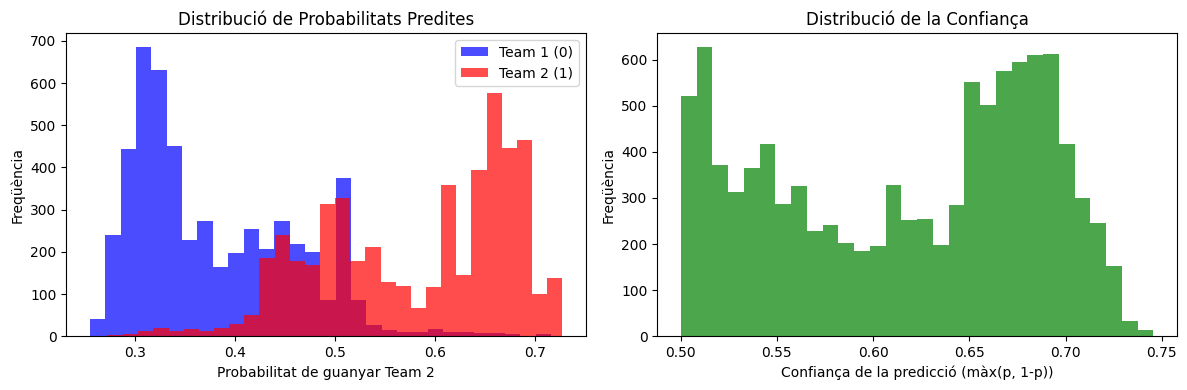

   Mitjana de confiança: 0.6165
   % prediccions amb confiança > 0.9: 0.0%

🔍 5. PROVA AMB MENYS DADES:


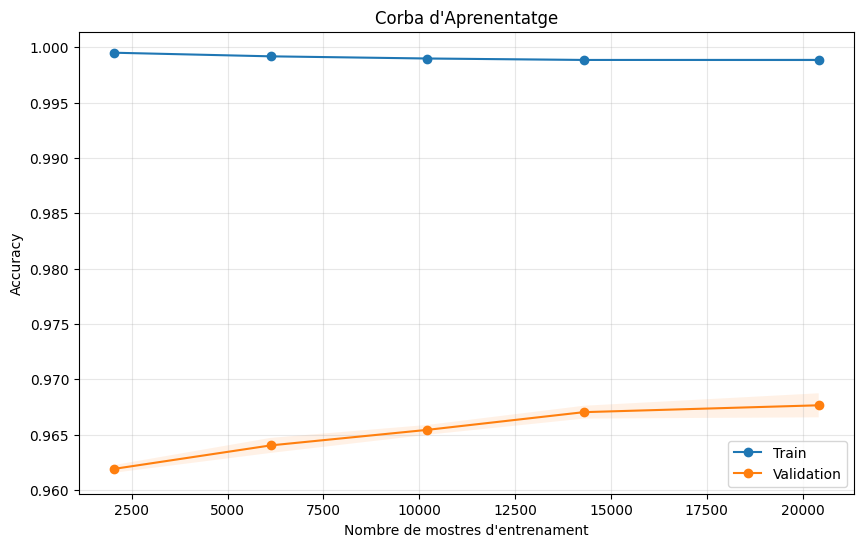


🔍 6. VERIFICANT SI EL PROBLEMA ÉS TRIVIAL...


In [34]:
# DIAGNÒSTIC DEL PROBLEMA
print(f"\n{'='*60}")
print("DIAGNÒSTIC: VERIFICANT PROBLEMES COMUNS")
print(f"{'='*60}")

# 1. Verificar si hi ha data leakage
print("\n🔍 1. BUSCANT DATA LEAKAGE...")

# a) Comprovar correlacions amb winner
print("\na) Top 10 correlacions amb 'winner':")
# Primer, crea una còpia temporal amb winner per calcular correlacions
temp_df = DataSet_cleaned.copy()
corr_with_target = temp_df.corr()['winner'].abs().sort_values(ascending=False)
print(corr_with_target.head(10))

# b) Buscar columnes que podrien contenir el resultat
print("\nb) Columnes que podrien contenir informació del resultat:")
keywords = ['win', 'kill', 'death', 'gold', 'tower', 'inhib', 'dragon', 'baron', 'herald']
for col in X.columns:
    col_lower = col.lower()
    for keyword in keywords:
        if keyword in col_lower:
            print(f"   - {col}")
            break

# 2. Model de línia base (baseline)
print("\n🔍 2. MODEL DE LÍNIA BASE (BASELINE):")
from sklearn.dummy import DummyClassifier

# Estratègia: predir la classe més freqüent
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train_scaled, y_train)
y_dummy_pred = dummy.predict(X_val_scaled)
dummy_acc = accuracy_score(y_val, y_dummy_pred)

print(f"   Accuracy del DummyClassifier: {dummy_acc:.4f}")
print(f"   Si el teu model ({best_model_name}) dona {best_model_info['val_metrics']['Accuracy']:.4f},")
print(f"   està millorant en {best_model_info['val_metrics']['Accuracy'] - dummy_acc:.4f}")

# 3. Anàlisi de les dades
print("\n🔍 3. ANÀLISI DE LES DADES:")
print(f"   Nombre total de mostres: {len(X)}")
print(f"   Nombre de característiques: {len(X.columns)}")

# 4. Distribució de probabilitats (si el model les dóna)
if hasattr(best_model, 'predict_proba'):
    print("\n🔍 4. DISTRIBUCIÓ DE PROBABILITATS:")
    y_proba = best_model.predict_proba(X_val_scaled)[:, 1]
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(y_proba[y_val == 0], bins=30, alpha=0.7, label='Team 1 (0)', color='blue')
    plt.hist(y_proba[y_val == 1], bins=30, alpha=0.7, label='Team 2 (1)', color='red')
    plt.xlabel('Probabilitat de guanyar Team 2')
    plt.ylabel('Freqüència')
    plt.title('Distribució de Probabilitats Predites')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    # Crear histograma de confiança
    confidence = np.where(y_proba > 0.5, y_proba, 1 - y_proba)
    plt.hist(confidence, bins=30, alpha=0.7, color='green')
    plt.xlabel('Confiança de la predicció (màx(p, 1-p))')
    plt.ylabel('Freqüència')
    plt.title('Distribució de la Confiança')
    
    plt.tight_layout()
    plt.show()
    
    print(f"   Mitjana de confiança: {confidence.mean():.4f}")
    print(f"   % prediccions amb confiança > 0.9: {(confidence > 0.9).mean()*100:.1f}%")

# 5. Prova amb un subconjunt de dades (learning curve simple)
print("\n🔍 5. PROVA AMB MENYS DADES:")
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train_scaled, y_train,
    cv=3, scoring='accuracy', n_jobs=-1,
    train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0]
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation')
plt.fill_between(train_sizes, 
                 train_scores.mean(axis=1) - train_scores.std(axis=1),
                 train_scores.mean(axis=1) + train_scores.std(axis=1),
                 alpha=0.1)
plt.fill_between(train_sizes,
                 val_scores.mean(axis=1) - val_scores.std(axis=1),
                 val_scores.mean(axis=1) + val_scores.std(axis=1),
                 alpha=0.1)
plt.xlabel('Nombre de mostres d\'entrenament')
plt.ylabel('Accuracy')
plt.title('Corba d\'Aprenentatge')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. Verificar si el problema és trivial
print("\n🔍 6. VERIFICANT SI EL PROBLEMA ÉS TRIVIAL...")

# Comptar quantes files tenen el mateix patró per ambdós equips
# (això podria indicar que alguna variable ho determina directament)

# Exemple: si hi ha una columna que és 1 per guanyador, 0 per perdedor
for col in X.columns:
    unique_vals = X[col].unique()
    if len(unique_vals) == 2 and set(unique_vals) == {0, 1}:
        # Verificar correlació perfecta
        correlation = np.corrcoef(X[col], y)[0, 1]
        if abs(correlation) > 0.95:
            print(f"   ALERTA: La columna '{col}' té correlació {correlation:.4f} amb 'winner'!")
            print(f"   Valors: {X[col].unique()}")
            print(f"   Potser és el resultat mateix disfressat!")

In [35]:

# DIAGNÒSTIC EXHAUSTIU - DETECCIÓ DE DATA LEAKAGE
print(f"\n{'='*80}")
print("🔍 DIAGNÒSTIC EXHAUSTIU: DETECCIÓ DE DATA LEAKAGE")
print(f"{'='*80}")

# 1. CORRELACIONS SOSPITOSES
print("\n1️⃣  TOP 30 CORRELACIONS AMB 'WINNER':")
print("="*60)
temp_df = DataSet_cleaned.copy()
corr_with_target = temp_df.corr()['winner'].abs().sort_values(ascending=False)
print(corr_with_target.head(30))

# 2. ANÁLISIS DE COLUMNAS PROBLEMÁTICAS
print("\n2️⃣  COLUMNES AMB CORRELACIÓ > 0.5:")
print("="*60)
high_corr = corr_with_target[corr_with_target > 0.5]
print(f"Total: {len(high_corr)} columnes")
for col, corr_val in high_corr.items():
    if col != 'winner':
        print(f"   • {col}: {corr_val:.4f}")

# 3. BASELINE COMPARISON
print("\n3️⃣  BASELINE (DUMMY CLASSIFIER):")
print("="*60)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_most_freq = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_most_freq.fit(X_train_scaled, y_train)
baseline_acc = dummy_most_freq.score(X_val_scaled, y_val)

print(f"   Dummy (most_frequent) Accuracy: {baseline_acc:.4f}")
print(f"   {best_model_name} Accuracy: {best_model_info['val_metrics']['Accuracy']:.4f}")
print(f"   Mejora: {best_model_info['val_metrics']['Accuracy'] - baseline_acc:.4f}")

if best_model_info['val_metrics']['Accuracy'] - baseline_acc < 0.05:
    print("   ⚠️  ALERTA: Mejora muy pequeña respecto a baseline!")

# 4. ANÁLISIS DE DISTRIBUCION DE DATOS
print("\n4️⃣  ANÁLISIS DE DISTRIBUCIÓN DE DATOS:")
print("="*60)
print(f"   • Total muestras: {len(X)}")
print(f"   • Total features: {len(X.columns)}")
print(f"   • Distribución target: {dict(y.value_counts())}")
print(f"   • % Train: {len(X_train)/len(X)*100:.1f}%")
print(f"   • % Val: {len(X_val)/len(X)*100:.1f}%")
print(f"   • % Test: {len(X_test)/len(X)*100:.1f}%")

# 5. PROBABILIDADES PREDICHAS
print("\n5️⃣  DISTRIBUCIÓN DE PROBABILIDADES:")
print("="*60)
if hasattr(best_model, 'predict_proba'):
    y_proba_val = best_model.predict_proba(X_val_scaled)[:, 1]
    confidence = np.where(y_proba_val > 0.5, y_proba_val, 1 - y_proba_val)
    
    print(f"   • Confianza media: {confidence.mean():.4f}")
    print(f"   • Confianza mín/máx: {confidence.min():.4f} / {confidence.max():.4f}")
    print(f"   • % predicciones > 0.9 confianza: {(confidence > 0.9).mean()*100:.1f}%")
    print(f"   • % predicciones > 0.95 confianza: {(confidence > 0.95).mean()*100:.1f}%")
    print(f"   • % predicciones > 0.99 confianza: {(confidence > 0.99).mean()*100:.1f}%")
    
    if (confidence > 0.95).mean() > 0.7:
        print("   ⚠️  ALERTA: ¡Demasiadas predicciones con confianza muy alta!")
        print("   Posible DATA LEAKAGE detectado.")

# 6. COMPARACIÓN VALIDACIÓN vs TEST
print("\n6️⃣  COMPARACIÓN VALIDACIÓN vs TEST:")
print("="*60)
print(f"   • Val Accuracy: {best_model_info['val_metrics']['Accuracy']:.4f}")
print(f"   • Test Accuracy: {test_metrics['Accuracy']:.4f}")
diff = abs(best_model_info['val_metrics']['Accuracy'] - test_metrics['Accuracy'])
print(f"   • Diferencia: {diff:.4f}")

if diff > 0.1:
    print("   ⚠️  ALERTA: ¡Gran diferencia entre validación y test!")
    print("   Posible OVERFITTING o DATA LEAKAGE.")

# 7. COLUMNAS SOSPECHOSAS
print("\n7️⃣  BÚSQUEDA DE COLUMNAS SOSPECHOSAS:")
print("="*60)
keywords = ['win', 'result', 'outcome', 'gold', 'kill', 'death', 'tower', 'inhib', 'dragon', 'baron']
suspicious = []
for col in X.columns:
    col_lower = col.lower()
    for keyword in keywords:
        if keyword in col_lower:
            suspicious.append(col)
            print(f"   ⚠️  {col}")
            break

if not suspicious:
    print("   ✅ No se encontraron columnas sospechosas obvias")

# 8. CORRELACIÓN PERFECTA
print("\n8️⃣  BÚSQUEDA DE CORRELACIONES PERFECTAS:")
print("="*60)
for col in X.columns:
    X_col = X[col].fillna(0)
    try:
        correlation = np.corrcoef(X_col, y)[0, 1]
        if abs(correlation) > 0.98:
            print(f"   ⚠️  {col}: correlación = {correlation:.4f}")
    except:
        pass

print("\n✅ DIAGNÓSTICO COMPLETADO")
print("="*80)


🔍 DIAGNÒSTIC EXHAUSTIU: DETECCIÓ DE DATA LEAKAGE

1️⃣  TOP 30 CORRELACIONS AMB 'WINNER':
winner                1.000000
t2_towerKills         0.785722
t1_towerKills         0.771571
t2_inhibitorKills     0.660696
t1_inhibitorKills     0.649636
firstInhibitor        0.536404
t2_dragonKills        0.497055
t1_dragonKills        0.472635
t2_baronKills         0.398692
firstTower            0.376347
t1_baronKills         0.369883
firstDragon           0.310220
firstBaron            0.261336
t2_riftHeraldKills    0.226131
t1_riftHeraldKills    0.218057
firstBlood            0.175564
firstRiftHerald       0.119891
t1_champ5id           0.026107
gameDuration          0.023514
t1_champ3id           0.020409
t1_champ1id           0.018570
t2_champ2id           0.018021
t1_champ4id           0.017609
t1_champ2id           0.015798
creationTime          0.015167
gameId                0.015016
t2_champ1id           0.013551
t2_champ5id           0.012234
t2_champ4id           0.011938
t2_champ3id